In [1]:
import xml.etree.ElementTree as ET
import html
import re
import pandas as pd
import logging
import MeCab
import fitz
import re
import sys
sys.path.append('/work_dir') 
import talknize_module_20240909 as tk
import csv
from collections import Counter
import itertools
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman
import network_plot_module as npm
import json

In [2]:
#前処理・関数定義領域

In [3]:
#形態素解析の前処理
#分析対象データの特性に対応するため、前処理はモジュールではなくコードとして記載
#talknize_module.pyにも標準的な処理も記載し、適宜使い分け可能にする

#----------------------------------------------------------------------
#テキストファイルの各行に記載された文字列を、処理用文字列として整形・リスト化
def text_to_list(file_path):

    # 空のリストを作成
    return_list = []
    try:
        # 指定されたファイルを読み込み、各行をリストに追加
        with open(file_path, 'r') as file:
            # ファイル内の各行をループし、行末の改行や余分な空白を除去してリストに格納
            return_list = [line.strip() for line in file]
    # ファイルが存在しない場合は例外を無視する
    except FileNotFoundError:
        pass
    # リストを返す
    return return_list

#----------------------------------------------------------------------
#形態素解析前のテキストデータ処理（
#形態素解析の前に、無駄な記号やヘッダ・フッタ等の文言をテキストから除外
def pre_tk(text, excl_list):

    replaced_text = text

    #exclusion_list処理前に処理する必要のあるもの
    #【特例処理】除外処理前に、文頭のこれら記号は「箇条書き」とみなし、続く文言を一文として扱う
    replaced_text = re.sub(r'[■□▪▫▲△▶▷▸▹▼▽◆◇●〇]', '。\n', replaced_text)
    #replaced_text = re.sub(r'[〇●◇◆□■▶△▲▽▼▫▪▹▶▸]', '', replaced_text)#上記以外は除去

    exclusion_list = []    
    exclusion_file1 = "userdic/exclusion_phrases1.txt"  # 各企業の除外フレーズを記載したリスト
    exclusion_file2 = "userdic/exclusion_codes.txt"  # その他記号・年月日・URL等を除外するためのリスト
    #exclusion_file3 = "userdic/exclusion_phrases2.txt"  # 各企業の除外フレーズを記載したリスト2（pageinfoから都度取り込み）
#    exclusion_list = text_to_list(exclusion_file1) + text_to_list(exclusion_file2)+ text_to_list(exclusion_file3)
    exclusion_list = excl_list + text_to_list(exclusion_file1) + text_to_list(exclusion_file2)

    for pattern in exclusion_list:
        replaced_text = re.sub(pattern, ' ', replaced_text)

    return replaced_text


In [4]:
#形態素解析の後処理
#形態素解析結果（tokenリスト）から、ストップワード、特定の条件の文字列等を除外
#import fitz
#import re
from collections import OrderedDict
import re

def post_tk(tokens):
    
    replaced_list = tokens    

    # stopwords（ファイルに格納）を除去
    path_stopwords = "userdic/stopwords.txt"
    stopwords = text_to_list(path_stopwords)
    stopwords = list(OrderedDict.fromkeys(stopwords)) # 元の順序を保持しつつ、重複を除去（# Python 3.7以降）
    replaced_list = [t for t in replaced_list if t not in stopwords]
    
    # ひらがなのみの要素を除去
    kana_re = re.compile("^[ぁ-ゖ]+$")
    replaced_list = [t for t in replaced_list if not kana_re.match(t)]

    # アルファベット1文字のみの要素を除去
    alphabet_re = re.compile("^[a-zA-Z]$")
    replaced_list = [t for t in replaced_list if not alphabet_re.match(t)]

    #特定の形態の数値要素を除去
    number_re = re.compile("^[\d,]+")
    replaced_list = [t for t in replaced_list if not number_re.match(t)]

    
    return replaced_list

In [5]:
#XMLからのテキスト抽出に用いる関数

def load_target_table_of_contents(df, target_columns):
    # 対象列で1が立っているキーワードのみ取得し、重複を除外
    try:
        return (
            df.loc[df[target_columns] == 1, 'keyword']
            .dropna()
            .drop_duplicates()
            .apply(str.strip)
            .tolist()
        )
    except:
        return []


def extract_content_by_keywords(xml_path, keywords):
    if not keywords:  # keywords が空なら空文字列を返す
        return ""

    tree = ET.parse(xml_path)
    root = tree.getroot()
    collected_text = []

    for page in root.findall('page'):
        tag_elem = page.find('tag')
        content_elem = page.find('content')

        if tag_elem is not None and content_elem is not None:
            tag_text = html.unescape((tag_elem.text or "").strip())

            # タグをカンマや全角カンマで分割し、前後の空白も削除
            tag_list = [t.strip() for t in re.split(r'[,]', tag_text) if t.strip()]

            # いずれかのタグがキーワードに完全一致するか
            if any(tag in keywords for tag in tag_list):
                raw_text = content_elem.text
                if raw_text:
                    decoded_text = html.unescape(raw_text)
                    cdata_match = re.search(r'<!\[CDATA\[(.*?)\]\]>', decoded_text, re.DOTALL)
                    if cdata_match:
                        collected_text.append(cdata_match.group(1).strip())

    return '\n\n'.join(collected_text)
    

In [6]:
# ログファイルの設定
log_filename = "data/logfile_TextMining.log"
logging.basicConfig(
    level=logging.INFO,  # ログレベルの設定 (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(levelname)s - %(message)s",  # ログのフォーマット
    handlers=[
        logging.FileHandler(log_filename, mode="a", encoding="utf-8"),  # ファイルに記録
        #logging.StreamHandler()  # コンソールにも出力
    ]
)

In [7]:
#共通
data_folder = 'data'
base_folder = 'ir/2025'
info_folder = 'info'
target_info_file = 'target_company_2025_tmp.csv'
target_info_path = data_folder + '/' + target_info_file
eliminate_list=[]

#==========================================================================
#動作モードの指定
#==========================================================================
#◆対象企業の読込方法   
#0はファイルから順次読込・処理、1は個別に指定
company_selection_mode = 1 
#◆XMLからの抽出範囲   
#0はcontents.csvで指定した範囲指定全て、1はマニュアル指定（リスト）
column_selection_mode = 0 
#◆出力ファイル出力方法　
#0は一つの企業ごとに複数の指定範囲を１ファイルで出力、1は企業ごと・指定範囲ごとに出力
file_output_mode =0 
#==========================================================================

#company_selection_mode = 1 の場合の個別指定項目
security_code = '79360'
company_name = 'アシックス'
industry_sector = 'その他製品'
target_folder = '79360_アシックス'
pdf_filename =  'file.pdf'
temp_list = [security_code, company_name, industry_sector, target_folder, pdf_filename]

#column_selection_mode = 1 の場合の抽出条件グループ
#target_columns = ['経営者', '価値創造', 'ESG', '財務', '知的資本', '人的資本', '流通', 'マーケティング', 'all']
target_columns = ['経営者']
# contents.csvのうち抽出条件範囲でない列を除外：これはmodeによらず共通
excluded_columns = ['keyword', 'page', 'origin', '表示']

#◆出力方法
#一括出力（企業ごとに、全ての抽出範囲を一つのファイルに格納し出力）
#個別出力（企業ごと・抽出範囲ごとにファイルを出力）

#ワードクラウド用設定
# 日本語フォントのパスを指定
jp_font_path = '/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'
# ワードクラウドのフォーマット指定
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path=jp_font_path)


In [8]:
#company_selection_modeに応じた処理
#企業ごとの処理
if company_selection_mode == 0 :
    df_target_company_info = pd.read_csv(target_info_path)
else:
    df_target_company_info = pd.DataFrame([temp_list],columns=['コード','企業名','業種分類','格納フォルダ','統合報告書PDF'])
#df_target_company_info

        業種    コード    企業名 分析範囲       単語  件数
6    その他製品  79360  アシックス  経営者    アシックス  39
153  その他製品  79360  アシックス  経営者    グローバル  28
254  その他製品  79360  アシックス  経営者    Sound  20
94   その他製品  79360  アシックス  経営者     デジタル  20
72   その他製品  79360  アシックス  経営者       地域  19
..     ...    ...    ...  ...      ...  ..
285  その他製品  79360  アシックス  経営者    マーケット   1
284  その他製品  79360  アシックス  経営者      マザー   1
283  その他製品  79360  アシックス  経営者       競合   1
281  その他製品  79360  アシックス  経営者  フットプリント   1
647  その他製品  79360  アシックス  経営者   Durand   1

[648 rows x 6 columns]


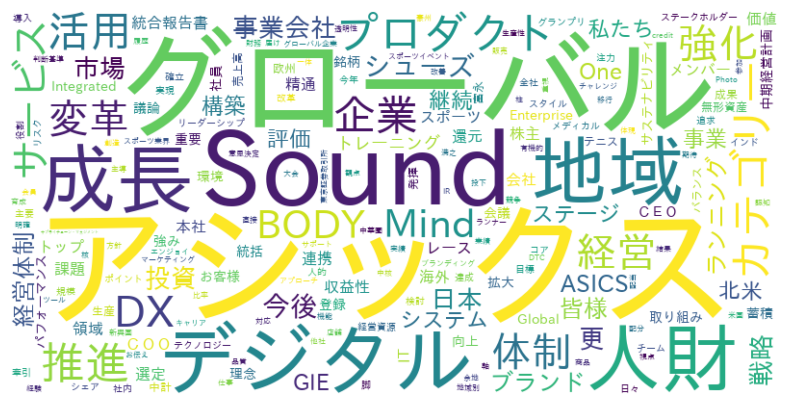

         業種    コード    企業名 分析範囲     1番目     2番目  count
0     その他製品  79360  アシックス  経営者    Mind   Sound     20
1     その他製品  79360  アシックス  経営者    BODY   Sound     20
2     その他製品  79360  アシックス  経営者   Sound   アシックス     14
3     その他製品  79360  アシックス  経営者   グローバル      人財     14
4     その他製品  79360  アシックス  経営者      DX      企業     14
...     ...    ...    ...  ...     ...     ...    ...
6690  その他製品  79360  アシックス  経営者   Albin   Photo      1
6691  その他製品  79360  アシックス  経営者  Durand   Photo      1
6692  その他製品  79360  アシックス  経営者   Albin  credit      1
6693  その他製品  79360  アシックス  経営者  Durand  credit      1
6694  その他製品  79360  アシックス  経営者   Albin  Durand      1

[6695 rows x 7 columns]
       コード    企業名 分析範囲    Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  経営者    Mind           0.027907                0.000946   
1    79360  アシックス  経営者   Sound           0.097674                0.063985   
2    79360  アシックス  経営者    BODY           0.027907                0.000946   
3    79360  アシックス  

<Figure size 640x480 with 0 Axes>

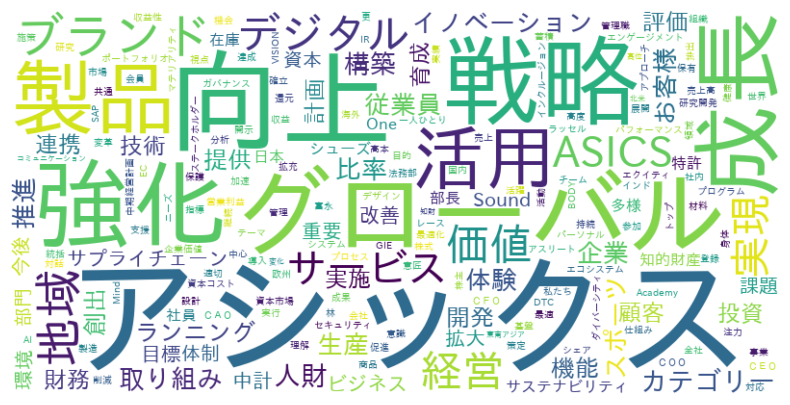

          業種    コード    企業名  分析範囲   1番目 2番目  count
0      その他製品  79360  アシックス  価値創造  ブランド  向上     33
1      その他製品  79360  アシックス  価値創造  ブランド  価値     31
2      その他製品  79360  アシックス  価値創造    価値  向上     30
3      その他製品  79360  アシックス  価値創造    −2  −2     30
4      その他製品  79360  アシックス  価値創造  ブランド  体験     29
...      ...    ...    ...   ...   ...  ..    ...
37403  その他製品  79360  アシックス  価値創造   メール  発信      1
37404  その他製品  79360  アシックス  価値創造   メール  延べ      1
37405  その他製品  79360  アシックス  価値創造   メール  回数      1
37406  その他製品  79360  アシックス  価値創造    延べ  発信      1
37407  その他製品  79360  アシックス  価値創造    回数  発信      1

[37408 rows x 7 columns]
       コード    企業名  分析範囲  Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  価値創造  ブランド           0.076596                0.023948   
1    79360  アシックス  価値創造    向上           0.187234                0.210608   
2    79360  アシックス  価値創造    価値           0.055319                0.009892   
3    79360  アシックス  価値創造    −2           0.025532                0.0002

<Figure size 640x480 with 0 Axes>

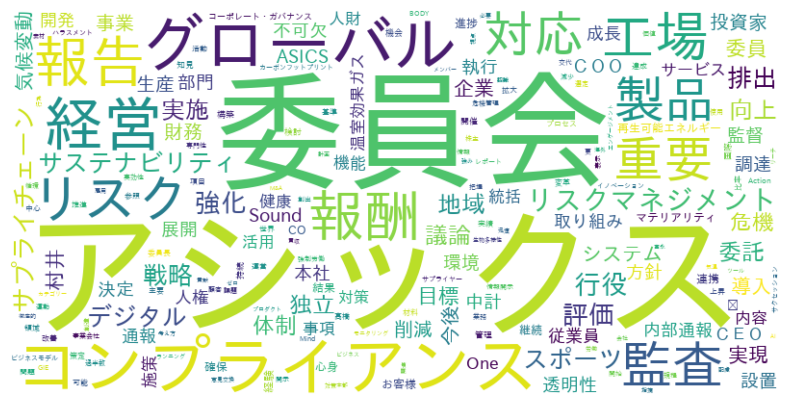

          業種    コード    企業名 分析範囲        1番目       2番目  count
0      その他製品  79360  アシックス  ESG         ⾏役        ⾏役     42
1      その他製品  79360  アシックス  ESG  リスクマネジメント       委員会     38
2      その他製品  79360  アシックス  ESG   コンプライアンス       委員会     34
3      その他製品  79360  アシックス  ESG   コンプライアンス  コンプライアンス     33
4      その他製品  79360  アシックス  ESG        委員会       委員会     31
...      ...    ...    ...  ...        ...       ...    ...
15756  その他製品  79360  アシックス  ESG        プラン        重要      1
15757  その他製品  79360  アシックス  ESG        プラン        事項      1
15758  その他製品  79360  アシックス  ESG        プラン        継続      1
15759  その他製品  79360  アシックス  ESG        プラン        審議      1
15760  その他製品  79360  アシックス  ESG         継続        重要      1

[15761 rows x 7 columns]
       コード    企業名 分析範囲       Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  ESG         ⾏役           0.163347                0.264127   
1    79360  アシックス  ESG  リスクマネジメント           0.083665                0.047310   
2    79360  アシ

<Figure size 640x480 with 0 Axes>

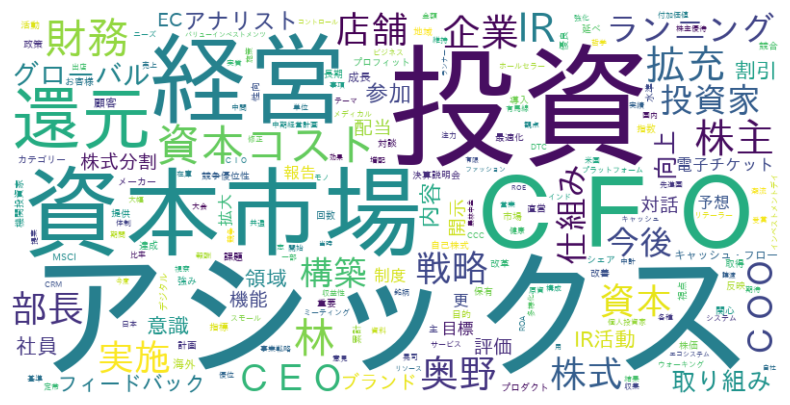

         業種    コード    企業名 分析範囲  1番目     2番目  count
0     その他製品  79360  アシックス   財務   財務     ＣＦＯ     18
1     その他製品  79360  アシックス   財務   部長     ＣＦＯ     18
2     その他製品  79360  アシックス   財務   割引  電子チケット     16
3     その他製品  79360  アシックス   財務   財務      部長     16
4     その他製品  79360  アシックス   財務  ＣＦＯ     ＣＯＯ     14
...     ...    ...    ...  ...  ...     ...    ...
5507  その他製品  79360  アシックス   財務  メール      発信      1
5508  その他製品  79360  アシックス   財務  メール      延べ      1
5509  その他製品  79360  アシックス   財務  メール      回数      1
5510  その他製品  79360  アシックス   財務   延べ      発信      1
5511  その他製品  79360  アシックス   財務   回数      発信      1

[5512 rows x 7 columns]
       コード    企業名 分析範囲     Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス   財務       財務           0.097046                0.072514   
1    79360  アシックス   財務      ＣＦＯ           0.118143                0.100841   
2    79360  アシックス   財務       部長           0.059072                0.003668   
3    79360  アシックス   財務       割引           0.054852 

<Figure size 640x480 with 0 Axes>

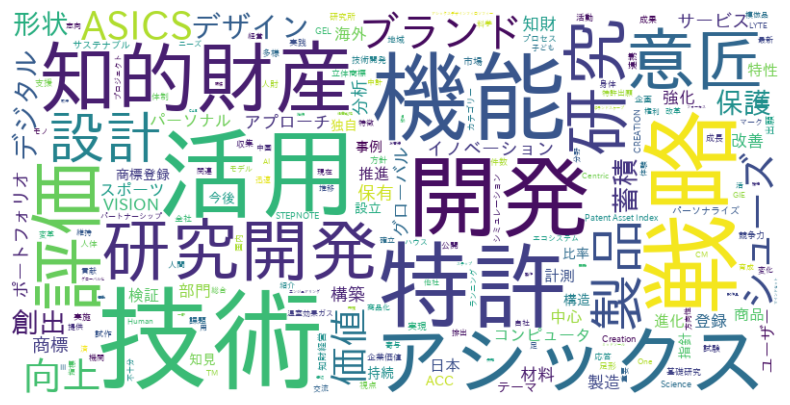

         業種    コード    企業名  分析範囲    1番目    2番目  count
0     その他製品  79360  アシックス  知的資本  アプローチ     改善     20
1     その他製品  79360  アシックス  知的資本  アプローチ     持続     13
2     その他製品  79360  アシックス  知的資本     保有     特許     13
3     その他製品  79360  アシックス  知的資本   シューズ     製造     13
4     その他製品  79360  アシックス  知的資本     機能     評価     12
...     ...    ...    ...   ...    ...    ...    ...
6721  その他製品  79360  アシックス  知的資本  グローバル  グローバル      1
6722  その他製品  79360  アシックス  知的資本   商標登録     知財      1
6723  その他製品  79360  アシックス  知的資本   商標登録     活動      1
6724  その他製品  79360  アシックス  知的資本     戦略     活動      1
6725  その他製品  79360  アシックス  知的資本   商標登録     戦略      1

[6726 rows x 7 columns]
       コード    企業名  分析範囲     Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  知的資本    アプローチ           0.106742                0.044523   
1    79360  アシックス  知的資本       改善           0.084270                0.018683   
2    79360  アシックス  知的資本       持続           0.050562                0.001514   
3    79360  アシックス  知的資本

<Figure size 640x480 with 0 Axes>

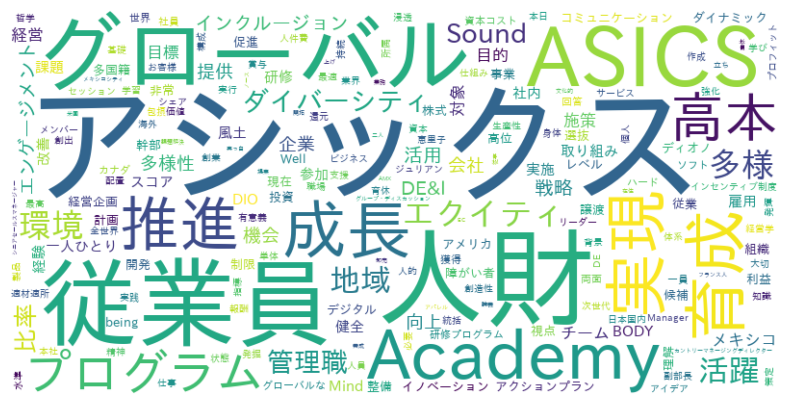

         業種    コード    企業名  分析範囲    1番目      2番目  count
0     その他製品  79360  アシックス  人的資本  ASICS  Academy     21
1     その他製品  79360  アシックス  人的資本     人財       育成     16
2     その他製品  79360  アシックス  人的資本  エクイティ  ダイバーシティ     14
3     その他製品  79360  アシックス  人的資本  アシックス       人財     13
4     その他製品  79360  アシックス  人的資本  グローバル       人財     13
...     ...    ...    ...   ...    ...      ...    ...
4505  その他製品  79360  アシックス  人的資本   取り組み       市場      1
4506  その他製品  79360  アシックス  人的資本   取り組み       理解      1
4507  その他製品  79360  アシックス  人的資本  アシックス       市場      1
4508  その他製品  79360  アシックス  人的資本  アシックス       理解      1
4509  その他製品  79360  アシックス  人的資本     市場       理解      1

[4510 rows x 7 columns]
       コード    企業名  分析範囲     Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  人的資本    ASICS           0.109756                0.110715   
1    79360  アシックス  人的資本  Academy           0.109756                0.110715   
2    79360  アシックス  人的資本       人財           0.256098                0.157324   

<Figure size 640x480 with 0 Axes>

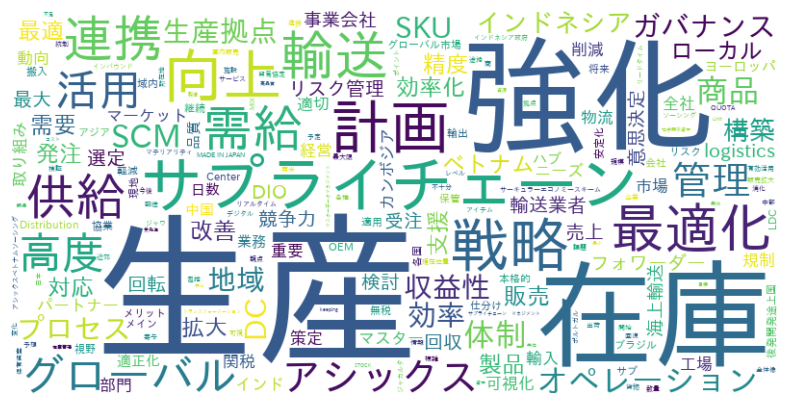

         業種    コード    企業名 分析範囲       1番目   2番目  count
0     その他製品  79360  アシックス   流通        強化    生産     11
1     その他製品  79360  アシックス   流通        向上    在庫     10
2     その他製品  79360  アシックス   流通    インドネシア    生産     10
3     その他製品  79360  アシックス   流通        供給    生産      9
4     その他製品  79360  アシックス   流通  サプライチェーン    生産      9
...     ...    ...    ...  ...       ...   ...    ...
3168  その他製品  79360  アシックス   流通      メリット    注視      1
3169  その他製品  79360  アシックス   流通     カンボジア  メリット      1
3170  その他製品  79360  アシックス   流通        動向    注視      1
3171  その他製品  79360  アシックス   流通     カンボジア    動向      1
3172  その他製品  79360  アシックス   流通     カンボジア    注視      1

[3173 rows x 7 columns]
       コード    企業名 分析範囲       Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス   流通         強化           0.163842                0.137304   
1    79360  アシックス   流通         生産           0.446328                0.486650   
2    79360  アシックス   流通         向上           0.129944                0.017196   
3    79

<Figure size 640x480 with 0 Axes>

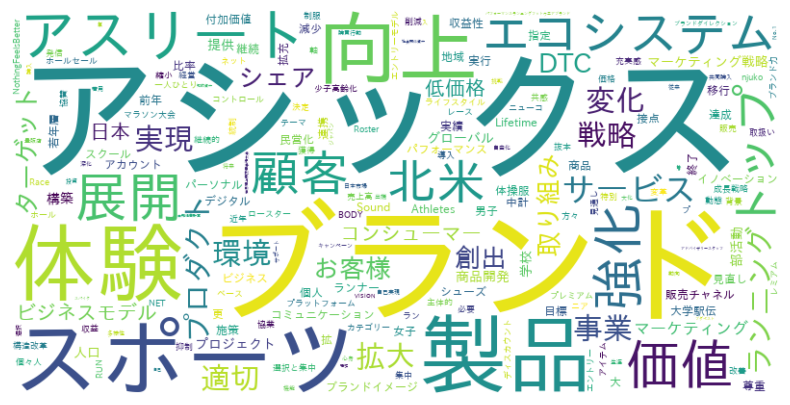

         業種    コード    企業名     分析範囲     1番目   2番目  count
0     その他製品  79360  アシックス  マーケティング      −2    −2     30
1     その他製品  79360  アシックス  マーケティング      −2    男子     20
2     その他製品  79360  アシックス  マーケティング      −2    女子     20
3     その他製品  79360  アシックス  マーケティング      −2    年末     10
4     その他製品  79360  アシックス  マーケティング      −2  高校駅伝     10
...     ...    ...    ...      ...     ...   ...    ...
2545  その他製品  79360  アシックス  マーケティング       プ    目標      1
2546  その他製品  79360  アシックス  マーケティング  TOPICS     プ      1
2547  その他製品  79360  アシックス  マーケティング      実績    目標      1
2548  その他製品  79360  アシックス  マーケティング  TOPICS    実績      1
2549  その他製品  79360  アシックス  マーケティング  TOPICS    目標      1

[2550 rows x 7 columns]
       コード    企業名     分析範囲  Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  マーケティング    −2           0.104712                0.082603   
1    79360  アシックス  マーケティング    男子           0.036649                0.003842   
2    79360  アシックス  マーケティング    女子           0.036649               

<Figure size 640x480 with 0 Axes>

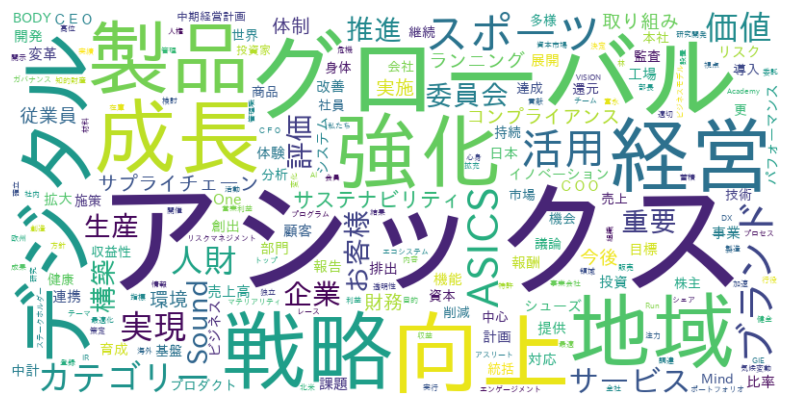

          業種    コード    企業名 分析範囲        1番目    2番目  count
0      その他製品  79360  アシックス  all       Mind  Sound     50
1      その他製品  79360  アシックス  all       BODY  Sound     50
2      その他製品  79360  アシックス  all         ⾏役     ⾏役     42
3      その他製品  79360  アシックス  all         地域     成長     41
4      その他製品  79360  アシックス  all  リスクマネジメント    委員会     38
...      ...    ...    ...  ...        ...    ...    ...
60495  その他製品  79360  アシックス  all        プラン     重要      1
60496  その他製品  79360  アシックス  all        プラン     事項      1
60497  その他製品  79360  アシックス  all        プラン     継続      1
60498  その他製品  79360  アシックス  all        プラン     審議      1
60499  その他製品  79360  アシックス  all         継続     重要      1

[60500 rows x 7 columns]
       コード    企業名 分析範囲   Node  Degree Centrality  Betweenness Centrality  \
0    79360  アシックス  all   Mind           0.013514                0.000000   
1    79360  アシックス  all  Sound           0.040541                0.000670   
2    79360  アシックス  all   BODY           0.013514              

<Figure size 640x480 with 0 Axes>

In [9]:
for index, row in df_target_company_info.iterrows():
    #target_folder = security_code + '_' + company_name

    #行ごとの値を読み込み
    row_security_code = row['コード']
    row_company_name = row['企業名']
    row_industy_sector = row['業種分類']
    row_pdf_filename =  row['統合報告書PDF']
    row_xml_filename = row_pdf_filename[:len(row_pdf_filename)-4] + '.xml'
    row_target_folder = base_folder + '/' +row['格納フォルダ']
    row_xml_path = row_target_folder + '/' + row_xml_filename
    row_info_folder = row_target_folder + '/' + info_folder
    row_contents_csv = row_info_folder + '/' + 'contents.csv'
    #print(row_security_code, row_info_folder, row_xml_filename)

    # contents.CSVを読み込む
    df_tbl_of_cnt = pd.read_csv(row_contents_csv)
    #print(df_tbl_of_cnt)
    # 対象の列を動的に抽出
    if column_selection_mode == 0:
        target_columns = [col for col in df_tbl_of_cnt.columns if col not in excluded_columns]
    #print(target_columns)

    df_count_combined = pd.DataFrame()
    df_combination_ex_combined = pd.DataFrame()    
    df_centrality_combined = pd.DataFrame()    
    
    #ファイル出力時に使用する年月日文字列の取得（全処理共通）
    # 現在の日付と時刻を取得
    now = datetime.datetime.now()
    # 年月日と時刻の文字列を生成
    date_time_string = now.strftime("%Y%m%d-%H%M%S")    
    
# 各ターゲット列について順に処理
    for col in target_columns:


        
        #print(f"\n=== タグ: {col} ===\n")
        target_table_of_contents = load_target_table_of_contents(df_tbl_of_cnt, col)
        output_text = extract_content_by_keywords(row_xml_path, target_table_of_contents)
        #print(output_text)

        #'。'で改行、一文の範囲を明確にする
        separated_text = re.sub(r'。','。\n', output_text)
        tokenized_text_list = post_tk(tk.mecab_tokenizer(pre_tk(separated_text, eliminate_list)))
        #Merged_Extracted_tokenized_list = [item for _, sublist in Extracted_tokenized_page_text for item in sublist]
        #print(tokenized_text_list)

        #辞書形式で単語をカウント
        counter = Counter(tokenized_text_list)
        # 単語、件数をDataFrameに格納
        df_count = pd.DataFrame(list(counter.items()), columns=['単語', '件数'])
        # DataFrameを件数でソート
        df_count = df_count.sort_values(by='件数', ascending=False)

        # 新しい列を追加
        df_count.insert(0, '業種', row_industy_sector)
        df_count.insert(1, 'コード', row_security_code)
        df_count.insert(2, '企業名', row_company_name)
        df_count.insert(3, '分析範囲', col)

        print(df_count)

        # 結果をCSVファイルに出力
        #個別に出力するパターン
        if file_output_mode == 1: 
            file_name = f"output/{row_security_code}_{row_company_name}_{col}_Word_list_{date_time_string}.csv"
            df_count.to_csv(file_name, encoding="utf_8_sig", index=False)        
        else:
            df_count_combined = pd.concat([df_count_combined, df_count], ignore_index=True)            

        #抽出単語によるワードクラウド作成
        # 単語とその頻度を辞書形式に変換
        word_freq = {word: freq for word, freq in zip(df_count['単語'], df_count['件数'])}
        # ワードクラウドの生成
        wordcloud.generate_from_frequencies(word_freq)
        # プロット
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
        
        # 結果をpngファイルに出力
        file_name_wordcloud = f'output/{row_security_code}_{row_company_name}_{col}_WordCloud_{date_time_string}.png'
        wordcloud.to_file(file_name_wordcloud)

        plt.clf()
        #plt.close()
        #tf-idf用に、ファイル名、企業名、トークンを出力
        #とりあえず略



        #各文中の、形態素組み合わせを作る
        #一文単位でトークンリストを作る
        sentences = [post_tk(tk.mecab_tokenizer(sentence)) for sentence in re.split("。", output_text)]
        #各文のトークンの組み合わせを作る
        #従来は全部の組み合わせ
        #sentence_combs = [list(itertools.combinations(sentence,2)) for sentence in sentences]
        #隣接する指定文字数内のトークンの組み合わせに限定
        max_distance = 10
        sentence_combs = [
            [(sentence[i], sentence[j]) 
             for i in range(len(sentence)) 
             for j in range(i + 1, min(i + 1 + max_distance, len(sentence)))]
            for sentence in sentences
        ]


        #print(sentences_combs[0])
        
        #組み合わせた2つの形態素の並びをソート
        words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentence_combs]
        #print(words_combs[0][:30])
        target_combs = []
        for words_comb in words_combs:
            target_combs.extend(words_comb)
        ct = Counter(target_combs)
        #print(ct)
        df_combination = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])
        df_combination_ex = df_combination.copy()
        # 新しい列を追加
        df_combination_ex.insert(0, '業種', row_industy_sector)
        df_combination_ex.insert(1, 'コード', row_security_code)
        df_combination_ex.insert(2, '企業名', row_company_name)
        df_combination_ex.insert(3, '分析範囲', col)

        print(df_combination_ex)

        #ファイル出力
        if file_output_mode == 1: 
            file_name_comb = f"output/{row_security_code}_{row_company_name}_{col}_Co-Occurrence_{date_time_string}.csv"
            df_combination_ex.to_csv(file_name_comb, encoding="utf_8_sig", index=False)
        else:
            df_combination_ex_combined = pd.concat([df_combination_ex_combined, df_combination_ex], ignore_index=True)  

        #########################################################
        # 分析対象とする共起単語の組み合わせ数（ノード数）を指定
        analyzed_links = 500
        limited_df = df_combination.head(analyzed_links)
        #########################################################

        # DataFrameからネットワークを作成
        G = nx.from_pandas_edgelist(limited_df, '1番目', '2番目', ['count'])

        # 各ノードの中心性を計算
        try:
            degree_centrality = nx.degree_centrality(G)
        except:
            degree_centrality = {node: '' for node in G.nodes()}
            
        try:
            betweenness_centrality = nx.betweenness_centrality(G)
        except:
            betweenness_centrality = {node: '' for node in G.nodes()}
        
        try:
            closeness_centrality = nx.closeness_centrality(G)
        except:
            closeness_centrality = {node: '' for node in G.nodes()}
        
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G)
        except:
            eigenvector_centrality = {node: '' for node in G.nodes()}
        
        try:
            katz_centrality = nx.katz_centrality(G)
        except:
            katz_centrality = {node: '' for node in G.nodes()}
        
        # Girvan-Newmanアルゴリズムでコミュニティに分割
        comp = girvan_newman(G)
        communities = tuple(sorted(c) for c in next(comp))
        
        # 各ノードがどのコミュニティに属するかを記録
        community_map = {}
        for i, community in enumerate(communities):
            for node in community:
                community_map[node] = i
        
        # 中心性を新しいデータフレームに格納
        df_centrality = pd.DataFrame({
            'コード': row_security_code,
            '企業名': row_company_name,
            '分析範囲': col,
            'Node': list(G.nodes()),
            'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
            'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
            'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
            'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
        #    'Katz Centrality': [katz_centrality[node] for node in G.nodes()],
            'Community': [community_map[node] for node in G.nodes()]  # コミュニティ情報を追加
            })
        print(df_centrality)

        if file_output_mode == 1: 
            file_name_centrality = f"output/{row_security_code}_{row_company_name}_{col}_Centrality_{analyzed_links}_{date_time_string}.csv"
            df_centrality.to_csv(file_name_centrality, encoding="utf_8_sig", index=False)
        else:
            df_centrality_combined = pd.concat([df_centrality_combined, df_centrality], ignore_index=True)
        
        
        
        #ネットワーク図を描画、ファイル出力
        got_net = npm.kyoki_word_network(limited_df)
        #フィルタボタンを表示させる場合は、set_optionを無効にする必要あり
        #got_net.show_buttons(filter_=['physics'])
        got_net.set_options("""
        const options = {
          "physics": {
            "forceAtlas2Based": {
              "centralGravity": 0.1,
              "springLength": 25,
              "springConstant": 0.1
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based"
          }
        }
        """)
        file_name_kyoki = f'output/{row_security_code}_{row_company_name}_{col}_kyoki_{analyzed_links}_{date_time_string}_.html'
        got_net.show(file_name_kyoki)

    
    if file_output_mode != 1:
        file_name = f"output/{row_security_code}_{row_company_name}_combined_Word_list_{date_time_string}.csv"
        df_count_combined.to_csv(file_name, encoding="utf_8_sig", index=False)

        file_name_comb = f"output/{row_security_code}_{row_company_name}_combined_Co-Occurrence_{date_time_string}.csv"
        df_combination_ex_combined.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

        file_name_centrality = f"output/{row_security_code}_{row_company_name}_combined_Centrality_{analyzed_links}_{date_time_string}.csv"
        df_centrality_combined.to_csv(file_name_centrality, encoding="utf_8_sig", index=False)

    print(f"processed {row_target_folder}/{row_xml_filename} at {date_time_string}.")